# Scenario 2: SIDARTHE model
This model is already annotated as a biomodels model (model BIOMD0000000955) and can be found here:
https://www.ebi.ac.uk/biomodels/BIOMD0000000955

In [1]:
from IPython.display import Image
from mira.sources.biomodels import get_template_model
from mira.modeling import Model
from mira.modeling.petri import PetriNetModel

# Get the model
sidarthe = get_template_model('BIOMD0000000955')
sidarthe.draw_graph('sidarthe.png')
assert sidarthe is not None

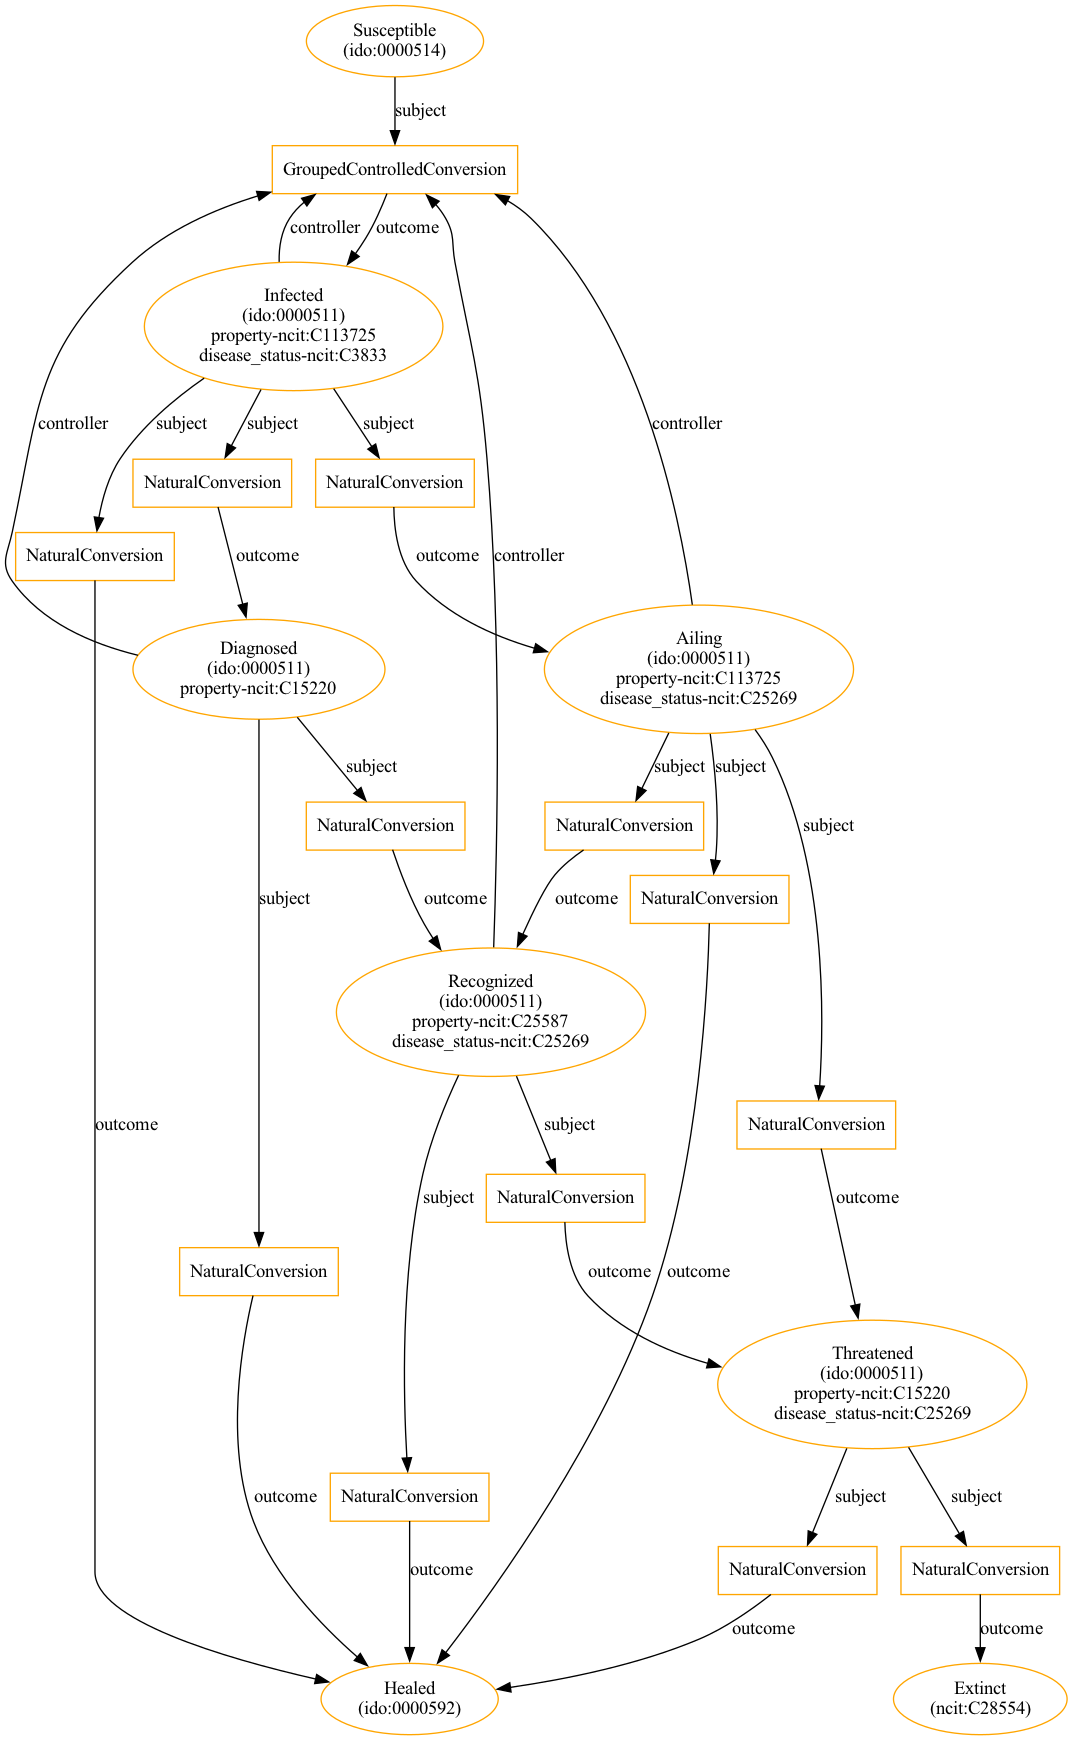

In [2]:
assert sidarthe is not None
Image('sidarthe.png')

In [3]:
pm = PetriNetModel(Model(sidarthe))
pm.to_json_file('scenario2_sidarthe.json', indent=1)

## Add vaccination
According to the scenario description, vaccination is added to the model and is described in this Nature paper: [https://www.nature.com/articles/s41591-021-01334-5](https://www.nature.com/articles/s41591-021-01334-5), see the graphics of the model here: [https://www.nature.com/articles/s41591-021-01334-5/figures/1](https://www.nature.com/articles/s41591-021-01334-5/figures/1)
The vaccination is added as immunizing vaccination, meaning when someone is vaccinated in this model, they are converted to an end-state in the model.

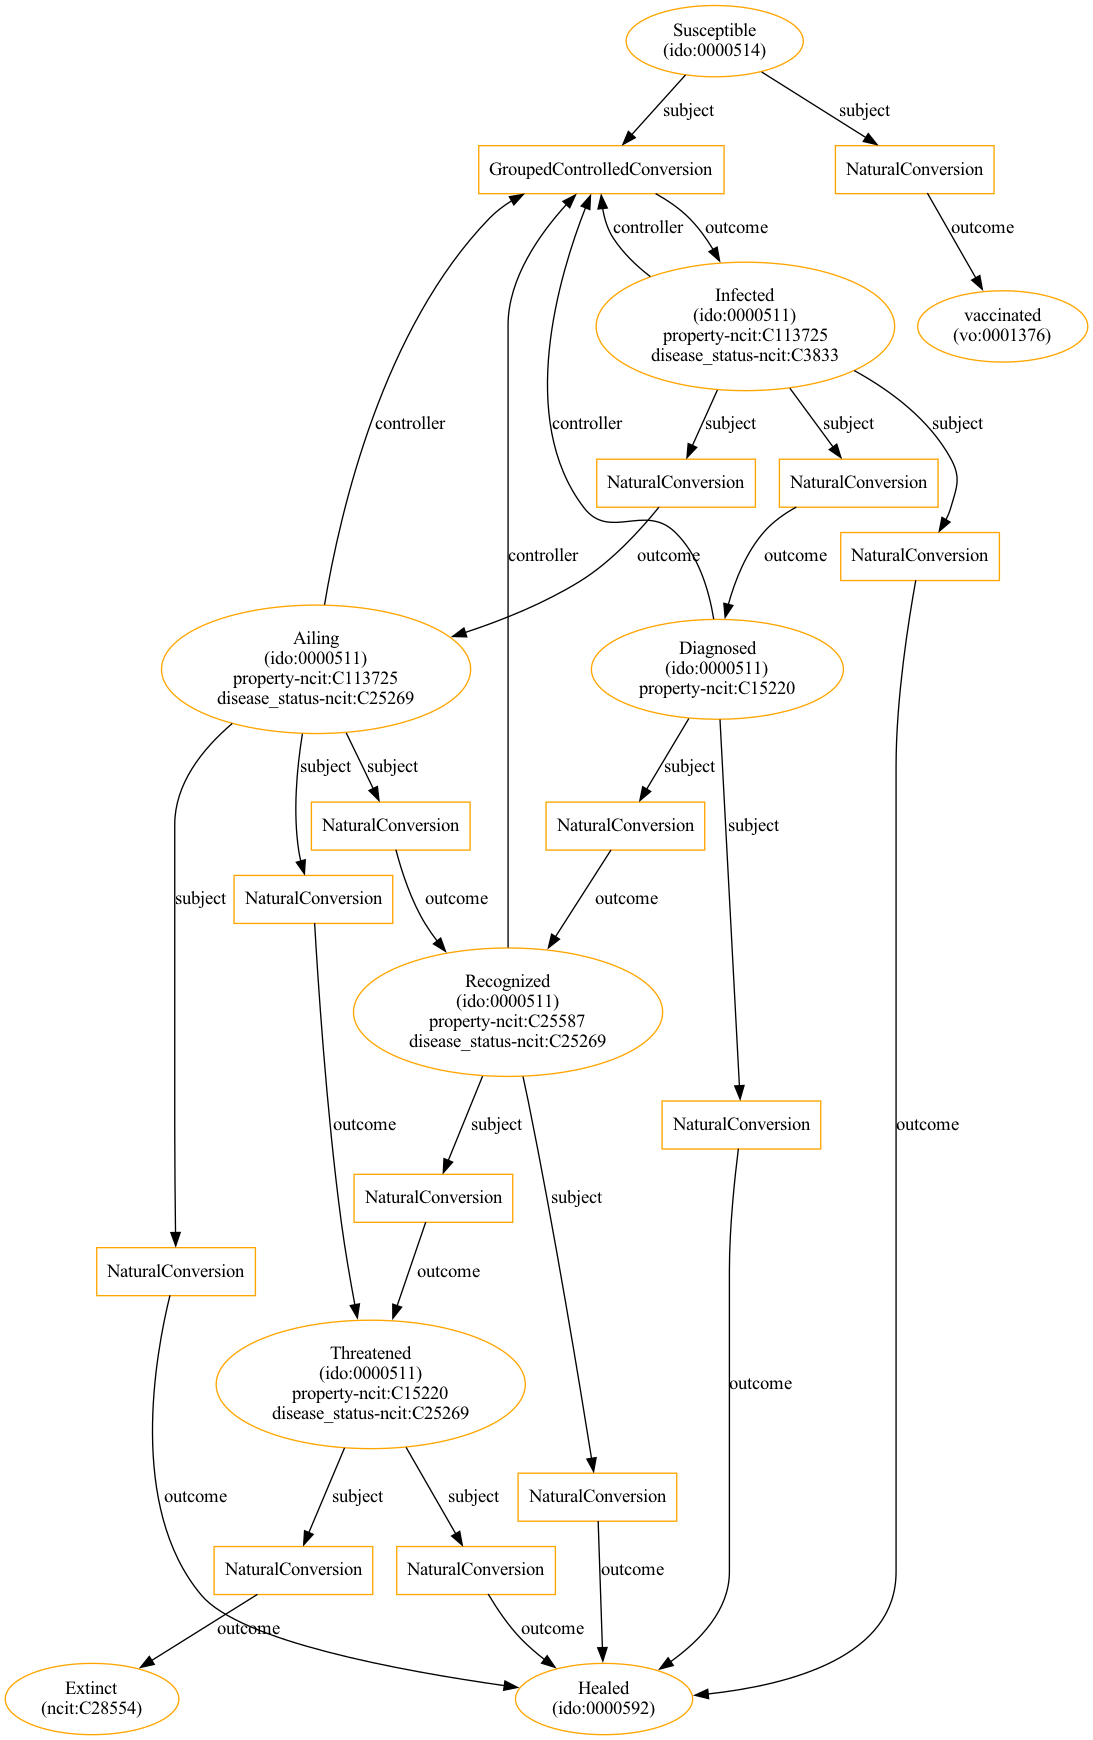

In [4]:
import sympy
from mira.metamodel import NaturalConversion, GroupedControlledConversion, Parameter
from mira.examples.concepts import vaccinated

# Extend the model with vaccination, first pick out the susceptible Concept that already exists in the model
susceptible = None
for template in sidarthe.templates:
    if isinstance(template, GroupedControlledConversion):
        susceptible = template.subject
        if susceptible.get_curie_str() == "ido:0000514":
            break
assert susceptible is not None

vaccination_rate = sympy.parse_expr("phi * Susceptible", local_dict={'phi': sympy.Symbol('phi')})
vaccination = NaturalConversion(subject=susceptible, outcome=vaccinated, rate_law=vaccination_rate)

# Create a new model with vaccination by adding the vaccination process to the existing model
sidarthe_v = sidarthe.add_template(vaccination)

# Get the GroupedControlledConversion template from the sidarthe_v model
grouped_controlled_conversion = None
for template in sidarthe_v.templates:
    if isinstance(template, GroupedControlledConversion):
        if template.subject.get_curie_str() == "ido:0000514":
            grouped_controlled_conversion = template
            break
assert grouped_controlled_conversion is not None

# Add the vaccination rate law
grouped_controlled_conversion.set_mass_action_rate_law("phi")
sidarthe_v.parameters['phi'] = Parameter(name="phi", value=1)

sidarthe_v.draw_graph('sidarthe_v.png')
Image('sidarthe_v.png')

In [ ]:
# Compare the models to see the difference
from mira.dkg.web_client import is_ontological_child_web
from mira.metamodel.templates import TemplateModelDelta

assert len(sidarthe.templates) > 0

tmd = TemplateModelDelta(sidarthe, sidarthe_v, refinement_function=is_ontological_child_web)

In [ ]:
tmd.draw_graph("sidarthe_v_diff.png")
Image('sidarthe_v_diff.png')

In [ ]:
# Export to Petrinet
sidarthe_v_petri = PetriNetModel(Model(sidarthe_v))
pm = PetriNetModel(Model(sidarthe_v_petri))
pm.to_json_file('scenario2_sidarthe_v.json', indent=1)